# Summary:
This notebook will first cover generating dataframes and dictionaries to set up connections among oncologists, cancer types and abstract ids (pmid). Secondly, it visualizes keywords in abstracts for each cancer type.

# Table of contents
* [1. Set up connections among oncologist, cancer type and abstract id](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 get pmid for each cancertype -- cancer2pmid_dict](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 get doctor for each cancertype -- cancer2doctor_dict](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 get doctor for pmid -- pmid2doctor_dict](#Part1.3_link)
<br >&nbsp;&nbsp;&nbsp;[1.4 get cancer for pmid -- pmid2cancer_dict](#Part1.4_link)
<br >&nbsp;&nbsp;&nbsp;[1.5 get cancer for doctor -- doctor2cancer_dict](#Part1.5_link)
<br >&nbsp;&nbsp;&nbsp;[1.6 get pmid for doctor -- doctor2pmid_dict](#Part1.6_link)
* [2. Visualize keywords for each cancer type](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Top 10 frequent keywords in each cancery type](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Visualize frequent words in each cancery type](#Part2.2_link)

In [99]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import defaultdict
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from ast import literal_eval

import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator

<a id='Part1_link'></a>
# 1. Set up connections among oncologist, cancer type and abstract id

<a id='Part1.1_link'></a>
## 1.1 get pmid for each cancertype -- cancer2pmid_dict

In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_catalog=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')

In [4]:
## get_pmid_for_cancertype for top 29 cancertypes
def get_pmid_for_cancertype(cancer_type,data=abstract_catalog):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df=data[data[cancer_type]==1]
    return list(np.array(subset_df.index))

In [10]:
cancertype_flattened_df=pd.read_csv(os.path.join(base_dir, "data/cancertype_df2.csv"))
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)

In [6]:
cancer2pmid_dict=dict()
for cancer_type in cancer_types[:29]:
    cancer2pmid_dict[cancer_type]=get_pmid_for_cancertype(cancer_type)

In [373]:
## get_pmid_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    cancer2pmid_dict[cancer_type]=list(pmid_temp)

In [ ]:
pickle.dump(cancer2pmid_dict, open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"), "wb"))

In [376]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

<a id='Part1.2_link'></a>
## 1.2 get doctor list for each cancertype -- cancer2doctor_dict

In [378]:
## get_doctor_for_cancertype for top 28 cancertypes
def get_doctor_for_cancertype(cancer_type):
    cancer_pmid=get_pmid_for_cancertype(cancer_type,data=abstract_catalog)
    doctor_list=[]
    for pmid in cancer_pmid:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    return list(set(doctor_list))

In [380]:
cancer2doctor_dict=dict()

In [381]:
for cancer_type in cancer_types[:29]:
    cancer2doctor_dict[cancer_type]=get_doctor_for_cancertype(cancer_type)

In [383]:
## get_doctor_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    doctor_list = []
    for pmid in pmid_temp:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    cancer2doctor_dict[cancer_type]=list(set(doctor_list))  

In [388]:
cancer2doctor_dict_counts=[len(cancer2doctor_dict[i]) for i in cancer2doctor_dict]

In [389]:
print(max(cancer2doctor_dict_counts))
print(min(cancer2doctor_dict_counts))

799
21


In [390]:
cancer2doctor_counts_df=pd.DataFrame({'cancer_type':list(cancer2doctor_dict.keys()), 'counts':cancer2doctor_dict_counts})
cancer2doctor_counts_df.head()

cancer_type  counts
0      Breast Cancer     799
1        Lung Cancer     777
2           Leukemia     537
3    Prostate Cancer     490
4  Colorectal Cancer     588

Text(0.5, 1.0, 'Number of oncologists for each cancer type')

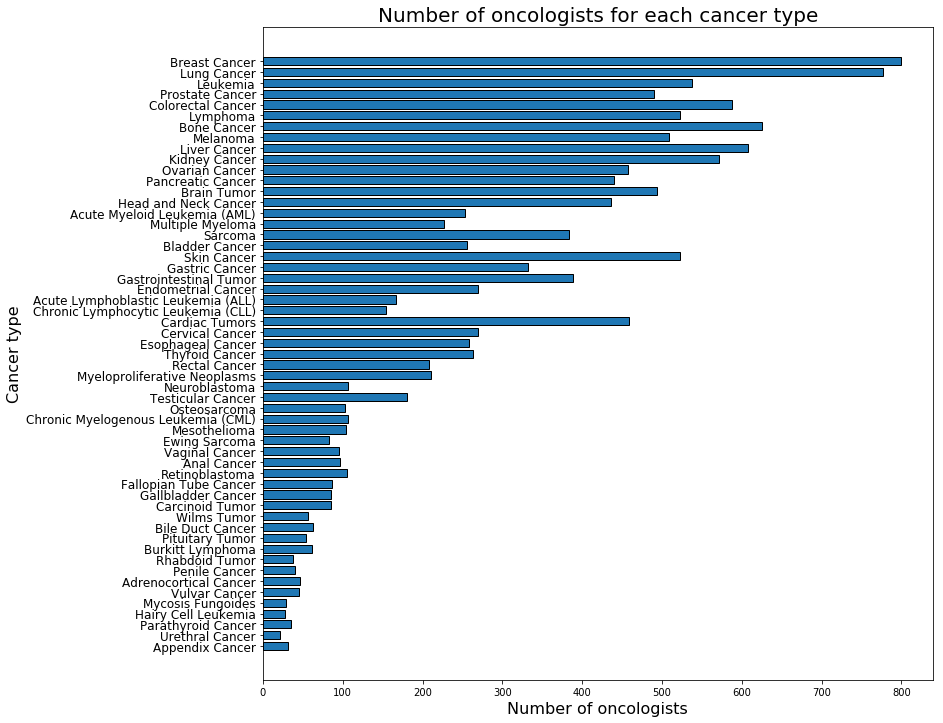

In [391]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(cancer2doctor_counts_df))  # the x locations for the groups
ax.barh(ind, cancer2doctor_counts_df.counts, width, edgecolor='black')
ax.invert_yaxis()
plt.yticks(ind, labels = cancer2doctor_counts_df.cancer_type, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('Number of oncologists', fontsize=16)
plt.title('Number of oncologists for each cancer type', fontsize=20)

<a id='Part1.3_link'></a>
## 1.3 get doctor for pmid -- pmid2doctor_dict

In [183]:
pmid2doctor_dict = defaultdict(list)

In [184]:
oncologist_speciality_pmid_df=pickle.load(open(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.pkl"),"rb"))

In [196]:
for pmid in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [445]:
pmid2doctor_dict_df = pd.DataFrame.from_dict(pmid2doctor_dict,orient='index')
pmid2doctor_dict_df['doctor'] = pmid2doctor_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
pmid2doctor_dict_df = pmid2doctor_dict_df.loc[:,'doctor'].to_frame()
pmid2doctor_dict_df.head()

doctor
10079468  [Hagop M. Kantarjian]
10581602    [Kenneth J. Pienta]
11719088  [James L. Abbruzzese]
11719506    [David Walterhouse]
11719516     [Karen E. Knudsen]

In [446]:
pmid2doctor_dict_df.to_csv(os.path.join(base_dir, 'data/pmid2doctor_dict_df.csv'),index=True,index_label='pmid')

In [214]:
pmid2doctor_counts_df = pd.DataFrame.from_dict(Counter(pmid2doctor_dict_counts), orient='index').rename(columns={0:'counts'})
pmid2doctor_counts_df.head()

counts
1   36913
2    8671
3    3132
4    1286
6     210

Text(0.5, 1.0, 'Number of oncologists for each abstract')

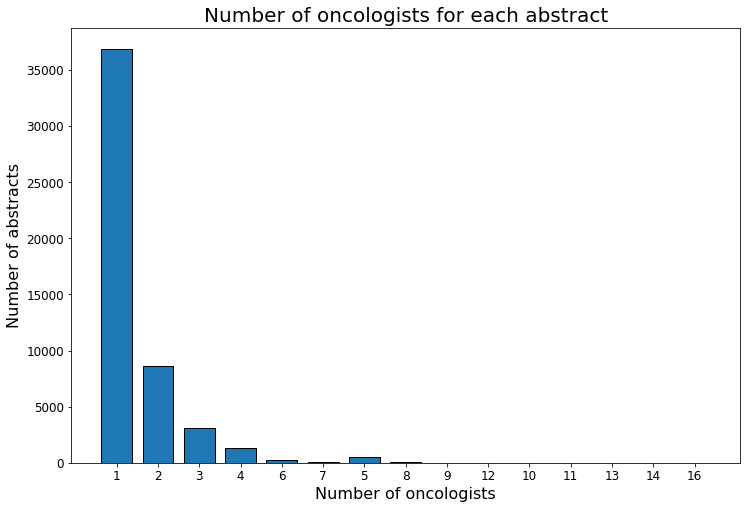

In [294]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(pmid2doctor_dict_counter))  # the x locations for the groups
ax.bar(ind, pmid2doctor_counts_df.counts, width, edgecolor='black')
plt.xticks(ind, labels = pmid2doctor_counts_df.index, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)]
plt.xlabel('Number of oncologists', fontsize=16)
plt.ylabel('Number of abstracts', fontsize=16)
plt.title('Number of oncologists for each abstract', fontsize=20)

Text(0.5, 0, 'Number of oncologists')

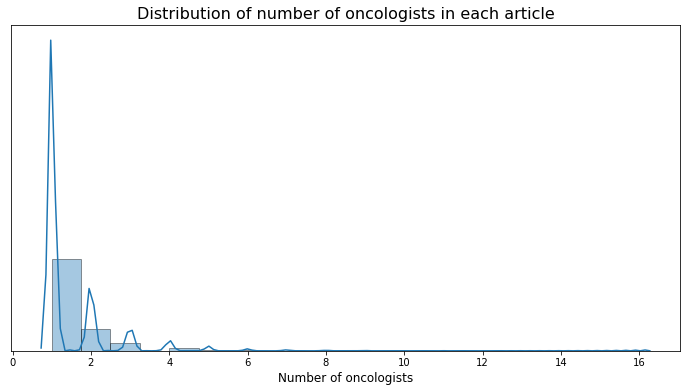

In [298]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(pmid2doctor_dict_counts,hist=True,bins=20,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of oncologists in each article',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of oncologists',fontsize=12)

<a id='Part1.4_link'></a>
## 1.4 get cancer for pmid -- pmid2cancer_dict

In [394]:
pmid2cancer_dict=dict()

In [395]:
for doctor in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [397]:
pickle.dump(pmid2cancer_dict, open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"), "wb"))

In [449]:
pmid2cancer_dict=pickle.load(open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"),"rb"))

<a id='Part1.5_link'></a>
## 1.5 get cancer for doctor -- doctor2cancer_dict

In [400]:
doctor2cancer_dict=defaultdict(list)

In [401]:
for cancer in cancer2doctor_dict:
    for doctor in cancer2doctor_dict[cancer]:
        doctor2cancer_dict[doctor].append(cancer)

In [402]:
len(doctor2cancer_dict)

1129

In [438]:
doctor2cancer_dict_df = pd.DataFrame.from_dict(doctor2cancer_dict,orient='index')
doctor2cancer_dict_df['cancer_type'] = doctor2cancer_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
doctor2cancer_dict_df = doctor2cancer_dict_df.loc[:,'cancer_type'].to_frame()
doctor2cancer_dict_df.head()

cancer_type
Andrea Silber        [Breast Cancer, Cardiac Tumors, Vaginal Cancer]
Celyne Bueno-Hume                                    [Breast Cancer]
Kathleen N. Moore  [Breast Cancer, Lung Cancer, Leukemia, Colorec...
Hossein Borghaei   [Breast Cancer, Lung Cancer, Leukemia, Colorec...
Eddy J. Chen                        [Breast Cancer, Prostate Cancer]

In [439]:
doctor2cancer_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2cancer_dict_df.csv'),index=True,index_label='name')

In [ ]:
doctor2cancer_dict_counts=[len(doctor2cancer_dict[i]) for i in doctor2cancer_dict]

Text(0.5, 0, 'Number of cancer types')

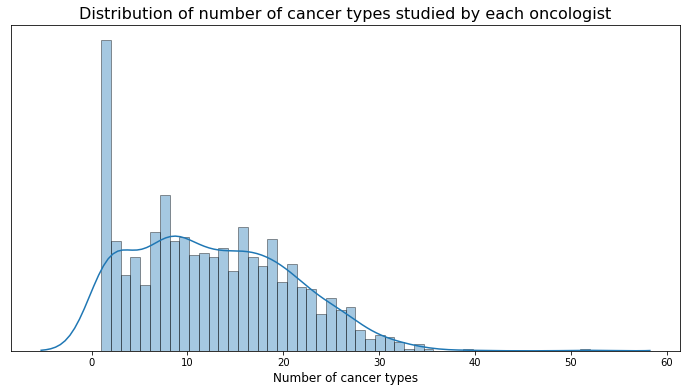

In [407]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(doctor2cancer_dict_counts,hist=True,bins=50,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of cancer types studied by each oncologist',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of cancer types',fontsize=12)

<a id='Part1.6_link'></a>
## 1.6 get pmid for doctor -- doctor2pmid_dict

In [431]:
doctor2pmid_dict2 = dict()

In [433]:
for doctor in doctor2pmid_dict:
    doctor2pmid_dict2[doctor]=list(oncologist_speciality_pmid_df.query('name=="{}"'.format(doctor)).pmid.unique())

In [434]:
len(doctor2pmid_dict2)

1153

In [436]:
pickle.dump(doctor2pmid_dict2, open(os.path.join(base_dir, "data/doctor2pmid_1153_dict3.pkl"), "wb"))

<a id='Part2_link'></a>
# 2. Visualize keywords for each cancer type

<a id='Part2.1_link'></a>
## 2.1 Top 10 frequent keywords in each cancery type

In [119]:
abstract_df=abstract_catalog.loc[:,["article_title","abstract","citation","pub_days"]]

In [102]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological','patient','disease',
                'therapy','dose','treatment','stage','year','level','response','case','month','clinical','specific',
                'associated','associate','rate','phase','carcinoma','expression','group','factor','trial','day','grade',
                'week','median','survival','risk']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [103]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>2 and temp not in stop_words:
            result.append(temp)
    return result

In [104]:
abstract_df['abstract_processed']=abstract_df.abstract.apply(lambda x:preprocess(x))

In [7]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [105]:
counter_dict={}

In [106]:
for cancer_type in cancer_types:
    pmid=cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid]
    corpus = subset_df.abstract_processed.sum()
    counter = Counter(corpus).most_common()
    counter_dict[cancer_type] = counter

In [107]:
counter_df=pd.DataFrame.from_dict(counter_dict, orient='index')
counter_df.head()

0              1                 2      \
Breast Cancer         (breast, 27046)  (woman, 8487)  (positive, 4951)   
Lung Cancer             (lung, 11694)  (nsclc, 5556)      (egfr, 4254)   
Leukemia             (leukemia, 8224)    (aml, 5035)     (acute, 3979)   
Prostate Cancer     (prostate, 13360)    (men, 3726)       (psa, 3330)   
Colorectal Cancer  (colorectal, 6061)    (crc, 2949)     (colon, 2788)   

                                  3                   4      \
Breast Cancer      (chemotherapy, 4622)    (receptor, 4174)   
Lung Cancer               (small, 3803)         (non, 3333)   
Leukemia                    (cll, 2842)     (myeloid, 2651)   
Prostate Cancer        (androgen, 2478)  (metastatic, 1961)   
Colorectal Cancer  (chemotherapy, 2042)   (resection, 1642)   

                                  5                   6      \
Breast Cancer              (brca, 3743)         (age, 3627)   
Lung Cancer        (chemotherapy, 3224)  (metastasis, 2912)   
Leukemia                (chronic, 2454)     (outcome, 2229)   
Prostate Cancer            (high, 1820)     (antigen, 1695)   
Colorectal Cancer    (metastasis, 1586)        (high, 1536)   

                                 7                 8                9      \
Breast Cancer         (negative, 3511)  (compared, 3309)      (use, 3083)   
Lung Cancer          (inhibitor, 2380)   (overall, 2307)  (treated, 2147)   
Leukemia             (inhibitor, 2104)      (high, 1974)  (overall, 1884)   
Prostate Cancer    (progression, 1637)      (time, 1626)    (model, 1616)   
Colorectal Cancer   (metastatic, 1435)  (compared, 1408)  (overall, 1393)   

                   ...            20895         20896             20897  \
Breast Cancer      ...  (intergrity, 1)  (carmine, 1)  (potentialty, 1)   
Lung Cancer        ...             None          None              None   
Leukemia           ...             None          None              None   
Prostate Cancer    ...             None          None              None   
Colorectal Cancer  ...             None          None              None   

                          20898            20899             20900      20901  \
Breast Cancer      (floquet, 1)  (multiplier, 1)  (nongenetics, 1)  (hook, 1)   
Lung Cancer                None             None              None       None   
Leukemia                   None             None              None       None   
Prostate Cancer            None             None              None       None   
Colorectal Cancer          None             None              None       None   

                       20902            20903            20904  
Breast Cancer      (hgma, 1)  (incapacity, 1)  (colloquium, 1)  
Lung Cancer             None             None             None  
Leukemia                None             None             None  
Prostate Cancer         None             None             None  
Colorectal Cancer       None             None             None  

[5 rows x 20905 columns]

In [108]:
counter10_df=counter_df.loc[:,:9]
counter10_df['counter10']=counter10_df.apply(lambda x: [x[i] for i in range(10)],axis=1)
counter10_df=counter10_df.loc[:,['counter10']]

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
def normalize_row(x):
    '''Normalize the keyword counts against the total number of top10 keyword counts in each class;
       The purpose is to evaluate the relative percentage of the top10 keyword counts in each class'''
    genes,repetition=zip(*x.counter10)
    t=sum(repetition)
    freqs=[np.round(r/t*100,2) for r in repetition]
    return list(zip(genes,freqs))

In [110]:
counter10_df['counter10_freq']=counter10_df.apply(lambda x:normalize_row(x),axis=1)
counter10_df.head()

counter10  \
Breast Cancer      [(breast, 27046), (woman, 8487), (positive, 49...   
Lung Cancer        [(lung, 11694), (nsclc, 5556), (egfr, 4254), (...   
Leukemia           [(leukemia, 8224), (aml, 5035), (acute, 3979),...   
Prostate Cancer    [(prostate, 13360), (men, 3726), (psa, 3330), ...   
Colorectal Cancer  [(colorectal, 6061), (crc, 2949), (colon, 2788...   

                                                      counter10_freq  
Breast Cancer      [(breast, 40.64), (woman, 12.75), (positive, 7...  
Lung Cancer        [(lung, 28.1), (nsclc, 13.35), (egfr, 10.22), ...  
Leukemia           [(leukemia, 24.64), (aml, 15.09), (acute, 11.9...  
Prostate Cancer    [(prostate, 40.18), (men, 11.21), (psa, 10.02)...  
Colorectal Cancer  [(colorectal, 26.54), (crc, 12.91), (colon, 12...

In [111]:
counter10_df_freq=pd.DataFrame.from_records(counter10_df.counter10_freq.values.tolist()).set_index(counter10_df.index)
counter10_df_freq.head()

0               1                 2  \
Breast Cancer          (breast, 40.64)  (woman, 12.75)  (positive, 7.44)   
Lung Cancer               (lung, 28.1)  (nsclc, 13.35)     (egfr, 10.22)   
Leukemia             (leukemia, 24.64)    (aml, 15.09)    (acute, 11.92)   
Prostate Cancer      (prostate, 40.18)    (men, 11.21)      (psa, 10.02)   
Colorectal Cancer  (colorectal, 26.54)    (crc, 12.91)    (colon, 12.21)   

                                      3                  4  \
Breast Cancer      (chemotherapy, 6.94)   (receptor, 6.27)   
Lung Cancer               (small, 9.14)        (non, 8.01)   
Leukemia                    (cll, 8.52)    (myeloid, 7.94)   
Prostate Cancer        (androgen, 7.45)  (metastatic, 5.9)   
Colorectal Cancer  (chemotherapy, 8.94)  (resection, 7.19)   

                                      5                  6  \
Breast Cancer              (brca, 5.62)        (age, 5.45)   
Lung Cancer        (chemotherapy, 7.75)  (metastasis, 7.0)   
Leukemia                (chronic, 7.35)    (outcome, 6.68)   
Prostate Cancer            (high, 5.47)     (antigen, 5.1)   
Colorectal Cancer    (metastasis, 6.94)       (high, 6.73)   

                                     7                 8                9  
Breast Cancer         (negative, 5.28)  (compared, 4.97)      (use, 4.63)  
Lung Cancer          (inhibitor, 5.72)   (overall, 5.54)  (treated, 5.16)  
Leukemia              (inhibitor, 6.3)      (high, 5.91)  (overall, 5.64)  
Prostate Cancer    (progression, 4.92)      (time, 4.89)    (model, 4.86)  
Colorectal Cancer   (metastatic, 6.28)  (compared, 6.16)   (overall, 6.1)

In [112]:
keywords10_all=[x for x in counter10_df_freq.sum().sum() if isinstance(x,str)]
keywords10_all_unique=list(set(keywords10_all))

In [113]:
cm = plt.get_cmap('RdBu', len(keywords10_all_unique))
colors = {k:cm(keywords10_all_unique.index(k)) for k in keywords10_all_unique}   ## 31
print(len(colors))

233


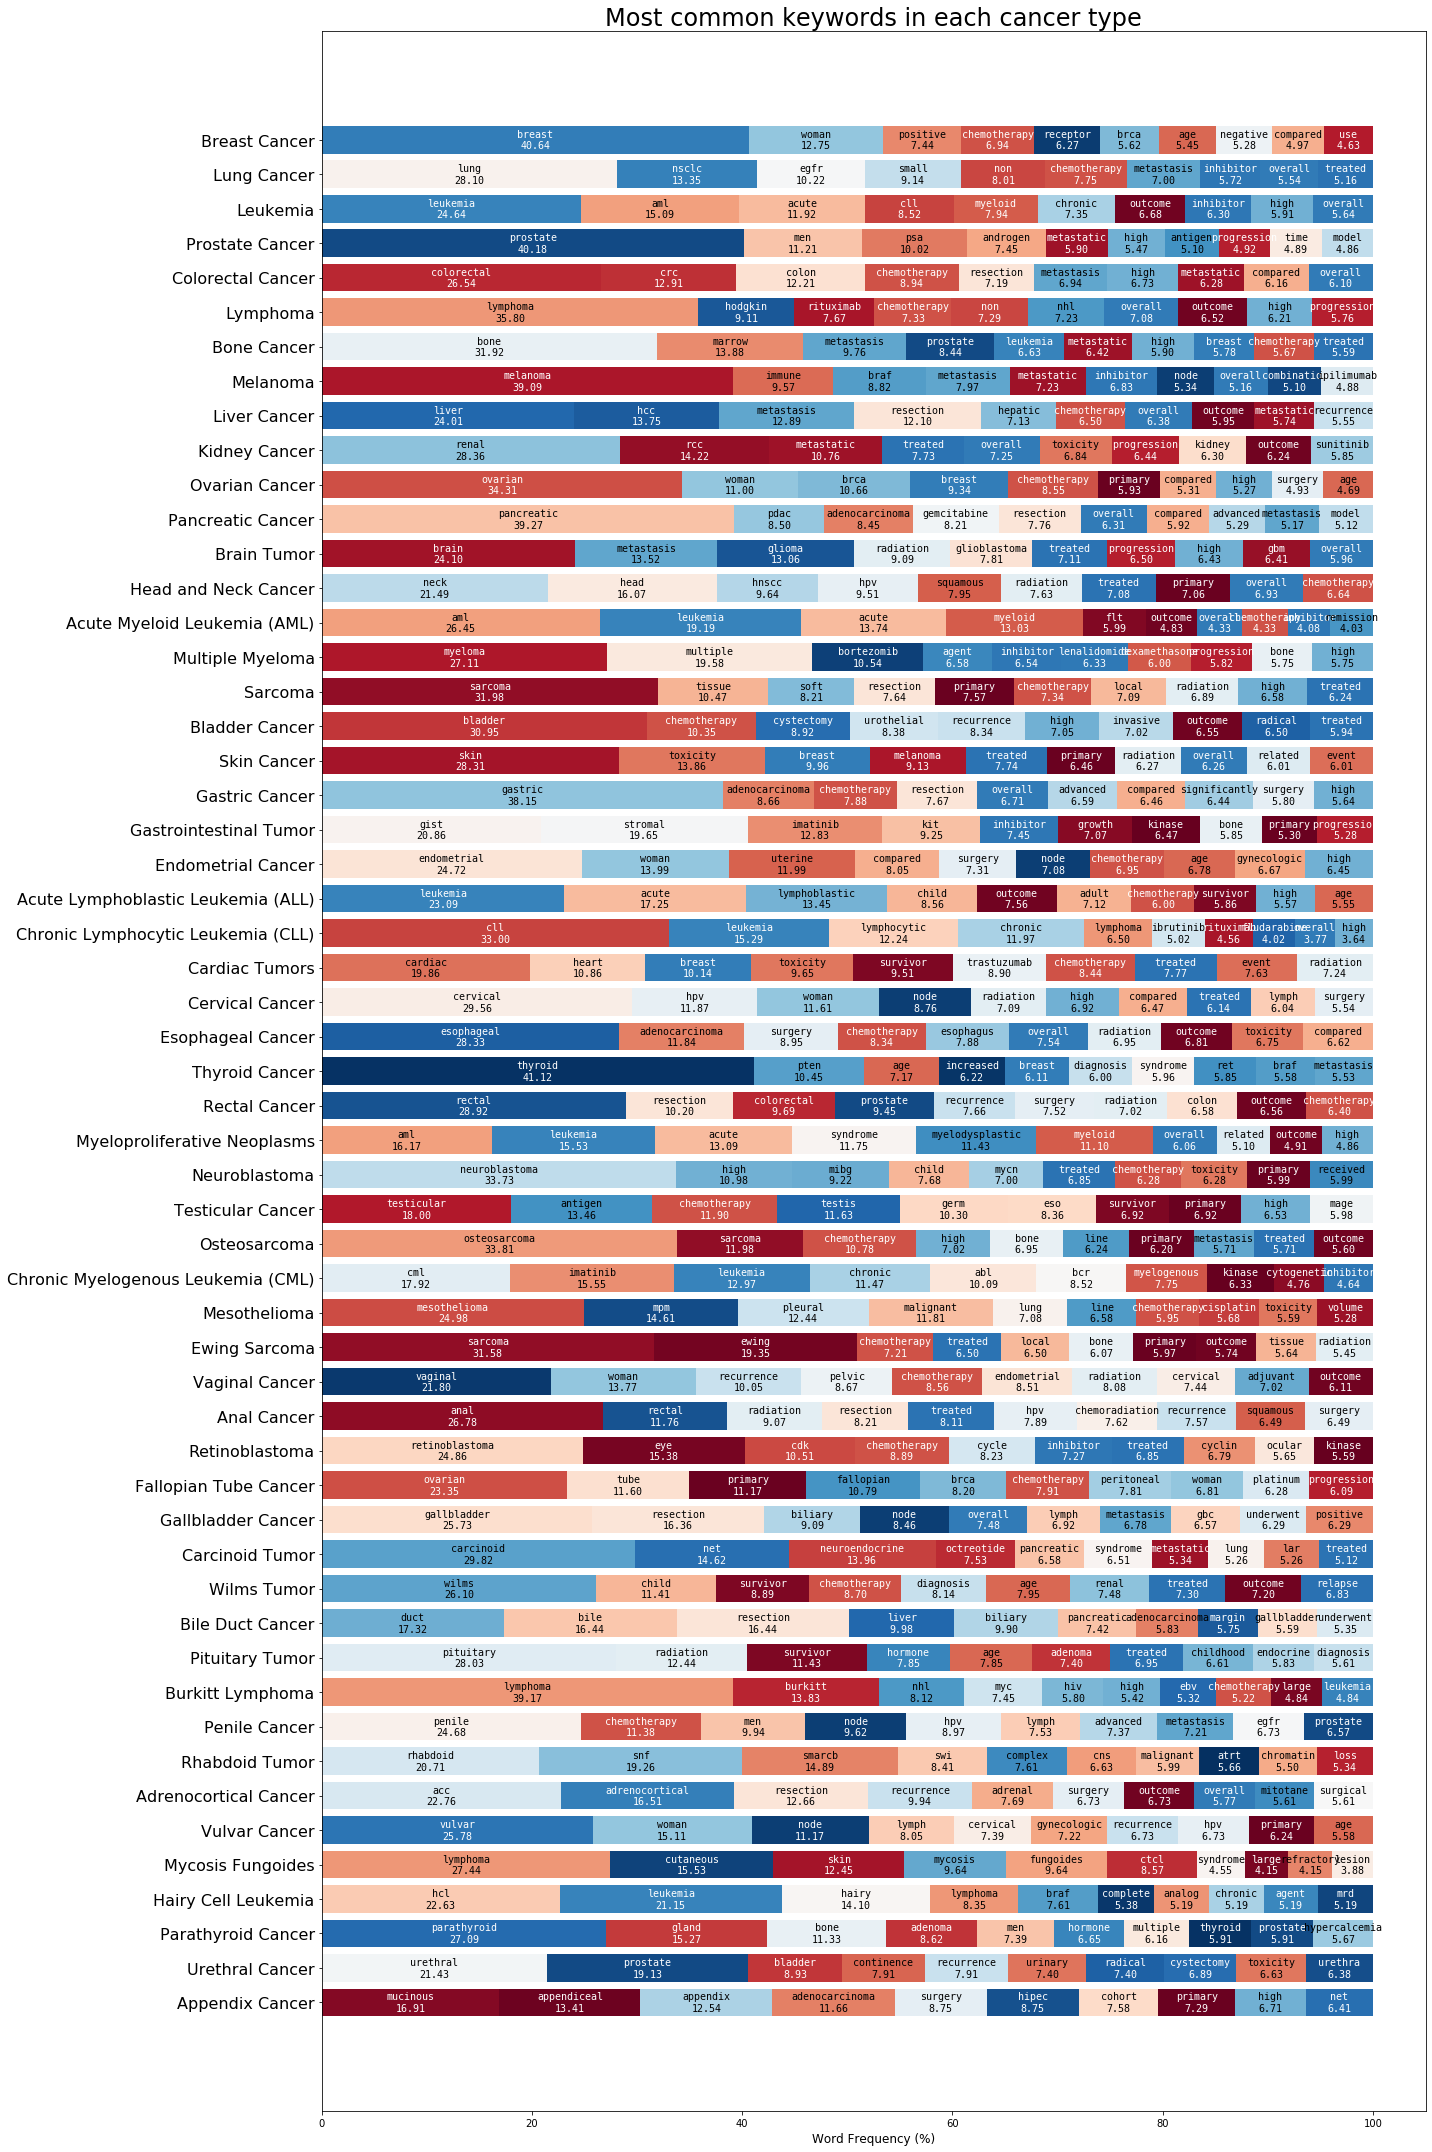

In [114]:
fig, ax = plt.subplots(figsize=(20,30))

offset = np.zeros(55)
for r in counter10_df_freq.iteritems():
    label, repetition = zip(*r[1])
    ax.barh(range(len(counter10_df_freq)), repetition, left=offset, color=[colors[l] for l in label])
    offset += repetition
    
ax.set_yticks(np.arange(len(counter10_df_freq)))
ax.set_yticklabels(counter10_df_freq.index,fontsize=16)
ax.invert_yaxis()

# annotate words
offset_x = np.zeros(55) 
for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%55] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2f}'.format(keywords10_all[idx], a.get_width()), 
            ha='center', va='center', color=fc, fontsize=10, family='monospace')
    offset_x[idx%55] += a.get_width()
    
ax.set_title('Most common keywords in each cancer type',fontsize=24)
ax.set_xlabel('Word Frequency (%)',fontsize=12)

plt.tight_layout()
plt.show()

<a id='Part2.2_link'></a>
## 2.2 Visualize frequent words in each cancery type

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


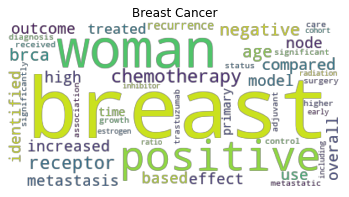

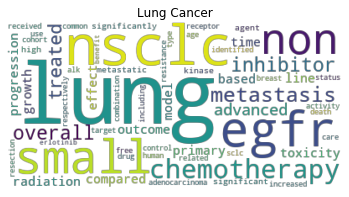

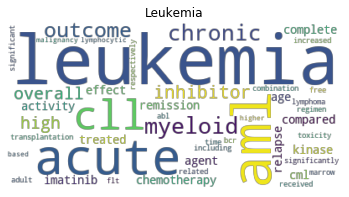

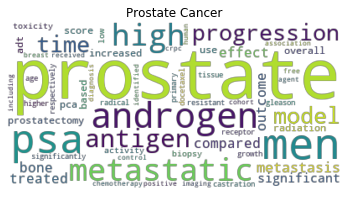

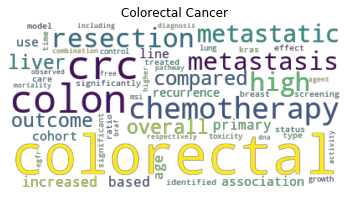

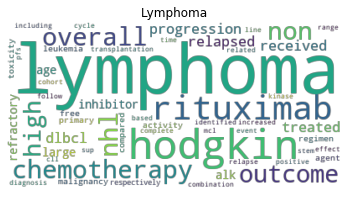

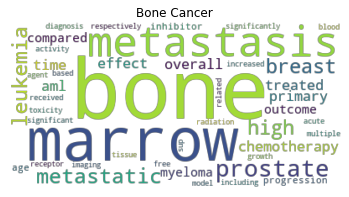

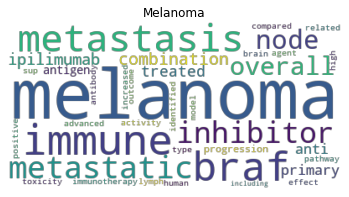

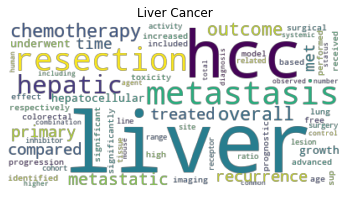

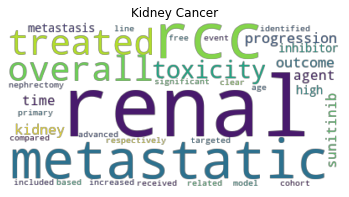

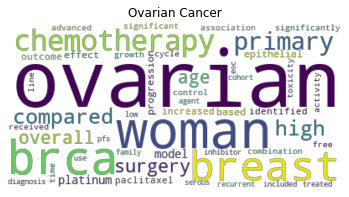

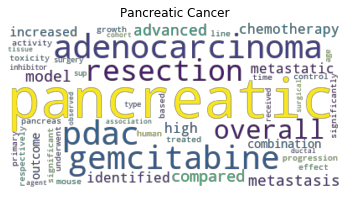

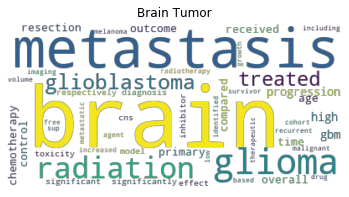

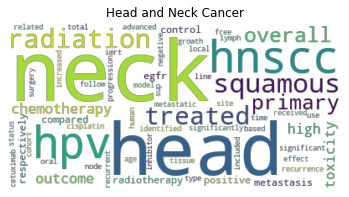

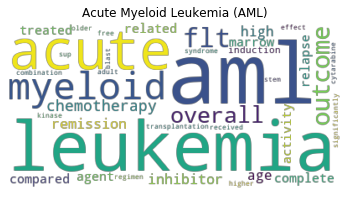

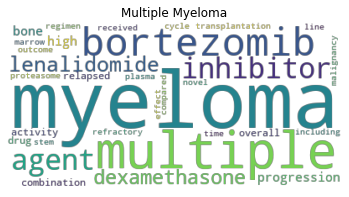

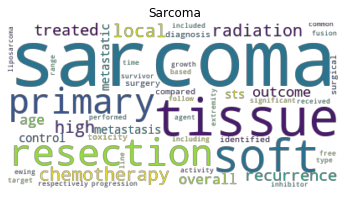

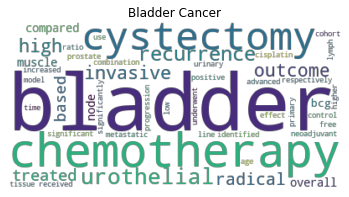

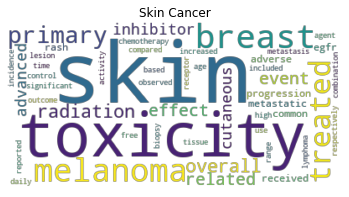

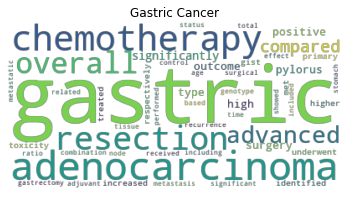

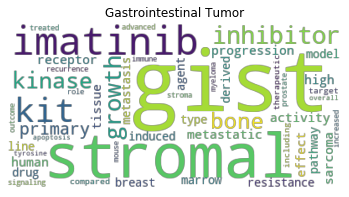

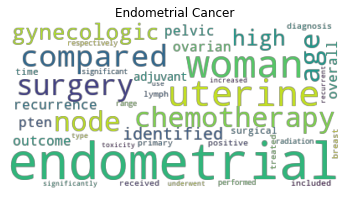

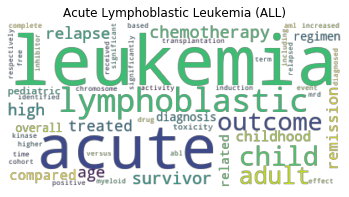

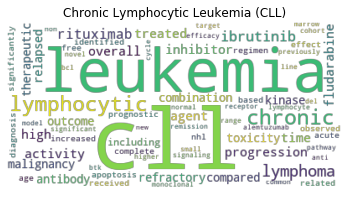

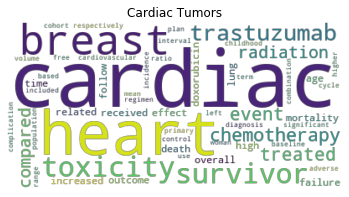

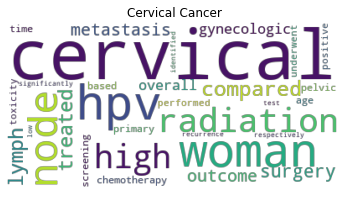

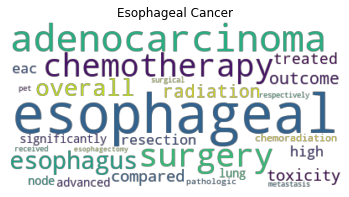

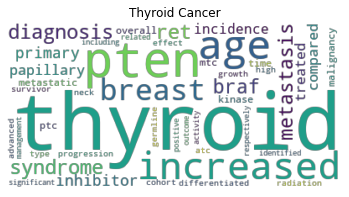

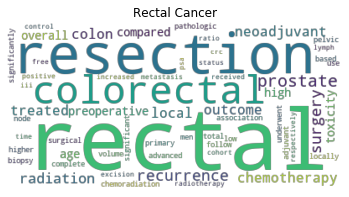

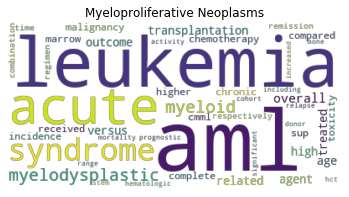

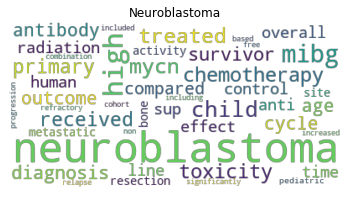

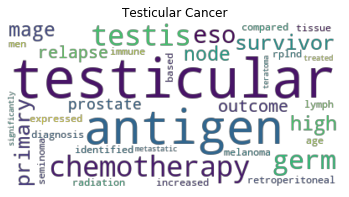

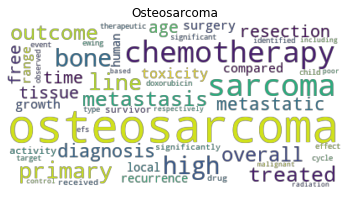

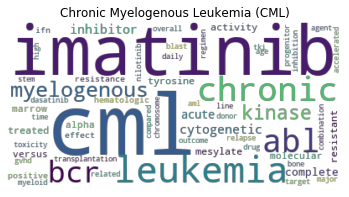

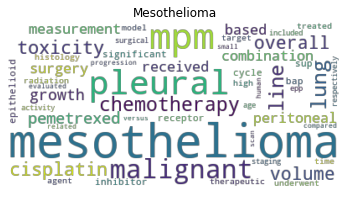

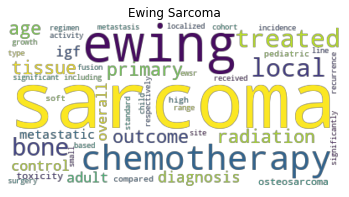

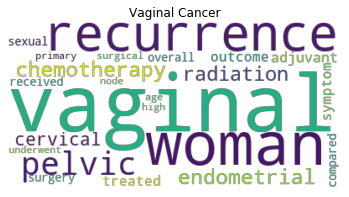

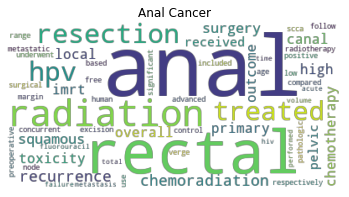

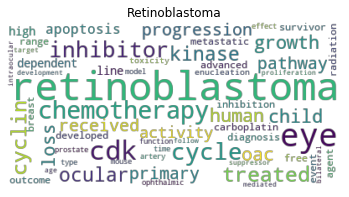

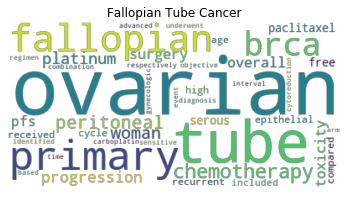

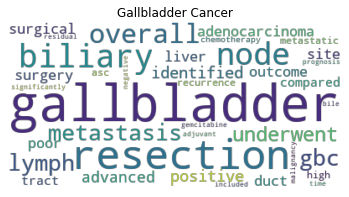

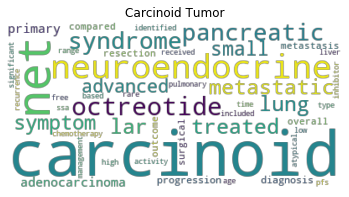

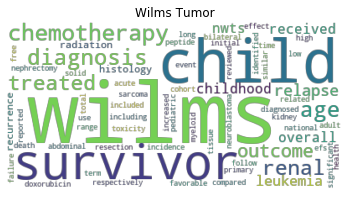

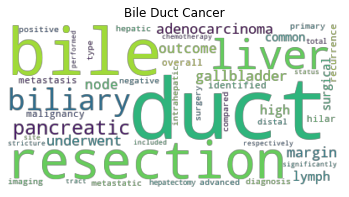

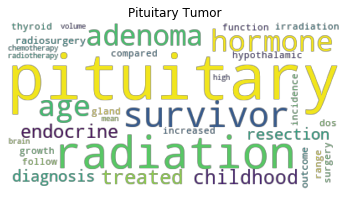

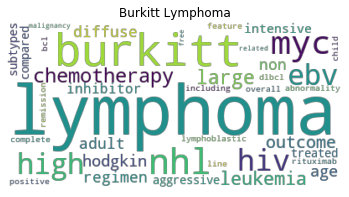

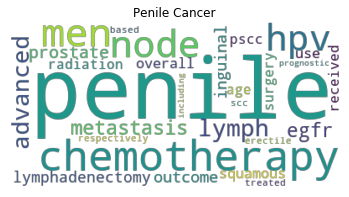

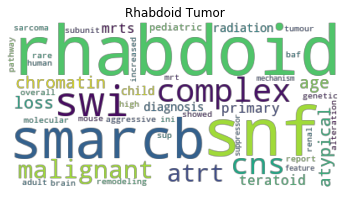

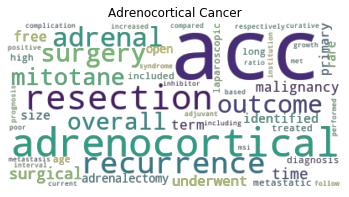

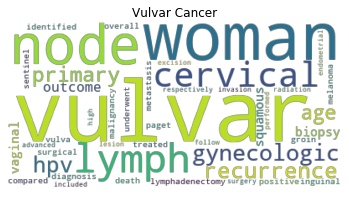

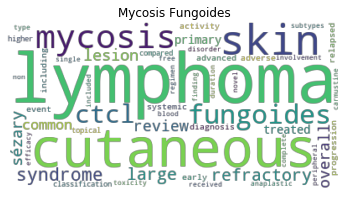

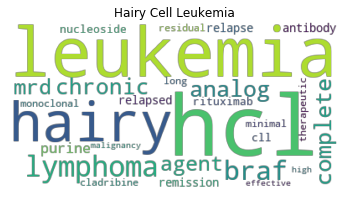

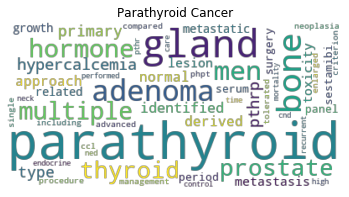

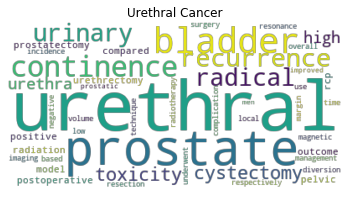

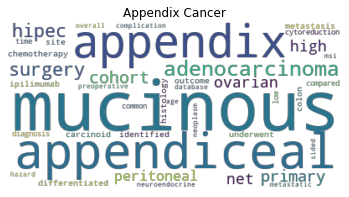

In [118]:
for cancer_type in cancer_types:
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid=cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid]
    corpus = subset_df.abstract_processed.sum()
    counter = Counter(corpus)
    
    wc = WordCloud(max_font_size=100,
               min_font_size=8,
               max_words=500,
               relative_scaling=.52,
               background_color=None,
               mode="RGBA").generate_from_frequencies(counter)
    plt.figure()
    plt.title(cancer_type,fontsize=12)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(os.path.join(base_dir, 'wordcloud/{}_wordcloud.png'.format(prefix)))